# Drug Name Detection 2

In [ ]:
# Average Fuzzy Similarity (Tesseract): ~22.6%
# Average Fuzzy Similarity (PaddleOCR): ~30.6%
# PaddleOCR handles multi-line text better than Tesseract in several examples, extracting cleaner segments like "Etoricoxib Tablet 120 mg."

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from paddleocr import PaddleOCR
import pandas as pd
from fuzzywuzzy import fuzz

In [2]:
# Set up paths
dataset_path = './Drug-Name/train/images'
train_images = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path) if img.endswith('.jpg')]

In [3]:
# Preprocessing function with enhancements
def preprocess_image(image_path):
    """
    Preprocess the image to enhance OCR performance.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image from path: {image_path}")
        return None

    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize and enhance contrast
    resized_img = cv2.resize(gray_img, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(resized_img)

    # Sharpen image
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Unsharp masking kernel
    sharpened_img = cv2.filter2D(enhanced_img, -1, kernel)

    # Denoise using bilateral filter
    denoised_img = cv2.bilateralFilter(sharpened_img, d=9, sigmaColor=75, sigmaSpace=75)

    # Thresholding
    _, binary_img = cv2.threshold(denoised_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Detect and correct skew using Hough Line Transform
    edges = cv2.Canny(binary_img, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
    if lines is not None:
        angles = [np.degrees(np.arctan2(y2 - y1, x2 - x1)) for x1, y1, x2, y2 in lines[:, 0]]
        median_angle = np.median(angles)
        h, w = binary_img.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, -median_angle, 1.0)
        corrected_img = cv2.warpAffine(binary_img, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return corrected_img

    return binary_img


In [4]:
# Tesseract OCR
def extract_text_with_tesseract(image_path):
    """
    Perform OCR using Tesseract.
    """
    preprocessed_img = preprocess_image(image_path)
    if preprocessed_img is None:
        return None

    custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'
    return pytesseract.image_to_string(preprocessed_img, config=custom_config).strip()

In [5]:
# PaddleOCR
ocr_model = PaddleOCR(use_angle_cls=True, lang='en')

def extract_text_with_paddleocr(image_path):
    """
    Perform OCR using PaddleOCR.
    """
    preprocessed_img = preprocess_image(image_path)
    if preprocessed_img is None:
        return None

    temp_file = "temp.jpg"
    cv2.imwrite(temp_file, preprocessed_img)
    result = ocr_model.ocr(temp_file, cls=True)
    if result and isinstance(result[0], list):
        return " ".join([line[1][0] for line in result[0]])
    return None

[2024/11/18 11:26:29] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\milto/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\milto/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

In [6]:
# Evaluation
def fuzzy_match(extracted_text, target_text):
    """
    Evaluate OCR text similarity with fuzzy matching.
    """
    if extracted_text is None or target_text is None:
        return 0
    return fuzz.ratio(extracted_text.lower(), target_text.lower())

In [7]:
# Logging Results
results = {
    "Image": [], "Tesseract Text": [], "PaddleOCR Text": [],
    "Fuzzy Similarity (Tesseract)": [], "Fuzzy Similarity (PaddleOCR)": []
}
target_text = "Xanser (Cetirizine Dihydrochloride) Oral Solution 60ml"

for img_path in train_images[:10]:  # Limit to 10 images for inspection
    tesseract_text = extract_text_with_tesseract(img_path)
    paddleocr_text = extract_text_with_paddleocr(img_path)

    tesseract_similarity = fuzzy_match(tesseract_text, target_text)
    paddleocr_similarity = fuzzy_match(paddleocr_text, target_text)

    results["Image"].append(img_path)
    results["Tesseract Text"].append(tesseract_text)
    results["PaddleOCR Text"].append(paddleocr_text)
    results["Fuzzy Similarity (Tesseract)"].append(tesseract_similarity)
    results["Fuzzy Similarity (PaddleOCR)"].append(paddleocr_similarity)

    print(f"Image: {img_path}")
    print(f"Tesseract Text: {tesseract_text}")
    print(f"PaddleOCR Text: {paddleocr_text}")
    print(f"Fuzzy Similarity (Tesseract): {tesseract_similarity}%")
    print(f"Fuzzy Similarity (PaddleOCR): {paddleocr_similarity}%")
    print("-" * 50)

[2024/11/18 11:26:32] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.6860198974609375
[2024/11/18 11:26:32] ppocr DEBUG: cls num  : 7, elapsed : 0.0962533950805664
[2024/11/18 11:26:33] ppocr DEBUG: rec_res num  : 7, elapsed : 0.9986164569854736
Image: ./Drug-Name/train/images\20230808_180909_jpg.rf.6b9f98f6097efe9f97f6c3309ad896e6.jpg
Tesseract Text: hMiCe2 7 ow re
a aff NY
EtoricoxibTablet120mg
Aaaratatnedo
o frcegtaPharmaceutlcalst1d 4
BraanidesduadZiabowe
DrakaAaylaten
ys cose ube ij
PaddleOCR Text: oncox'120 Etoricoxib Tabtet 120 mg Watatue  (ncegta Pharmaceukals tid n aka Anylastn
Fuzzy Similarity (Tesseract): 28%
Fuzzy Similarity (PaddleOCR): 32%
--------------------------------------------------
[2024/11/18 11:26:34] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.25272297859191895
[2024/11/18 11:26:34] ppocr DEBUG: cls num  : 9, elapsed : 0.0546727180480957
[2024/11/18 11:26:35] ppocr DEBUG: rec_res num  : 9, elapsed : 0.9382541179656982
Image: ./Drug-Name/train/images\20230808_181538_

Results saved to 'ocr_evaluation_results_updated.csv'.


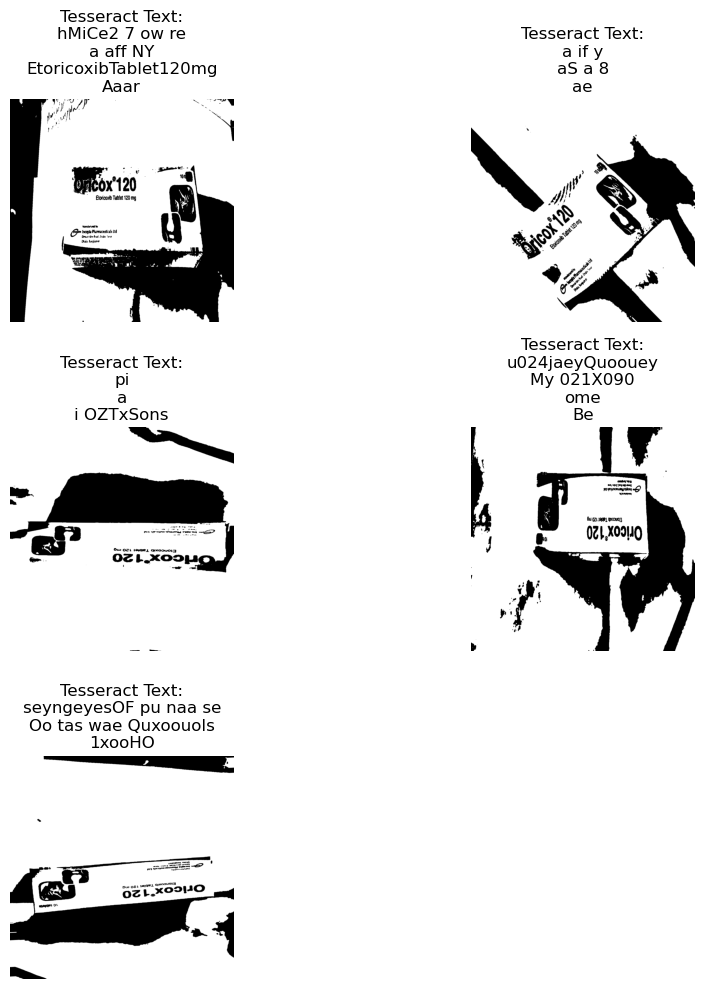

In [8]:
# Save Results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("ocr_evaluation_results_updated.csv", index=False)
print("Results saved to 'ocr_evaluation_results_updated.csv'.")

# Visualize Preprocessed Images and Text
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(train_images[:5]):  # Limit to 5 images for visualization
    preprocessed_img = preprocess_image(img_path)
    tesseract_text = extract_text_with_tesseract(img_path)
    
    plt.subplot(3, 2, i + 1)
    if preprocessed_img is not None:
        plt.imshow(preprocessed_img, cmap='gray')
    plt.axis('off')
    plt.title(f"Tesseract Text:\n{tesseract_text[:50]}")  # Display first 50 characters of text
plt.tight_layout()
plt.show()


In [ ]:
# Next Steps for Improvement

#V To refine and build on these results:

# Focus on PaddleOCR:
# Fine-tune it further for your dataset by using domain-specific text samples.

# Adjust hyperparameters and augmentations to handle variability better.
# Preprocessing for Tesseract:
# Continue refining preprocessing steps in (B) to improve text clarity and edge detection.
# Explore options like custom-trained Tesseract models for pharmaceutical terms.

# Segmentation Improvements:
# Use bounding boxes to isolate text regions and test OCR separately on smaller, less cluttered areas.